# Imports, constants and functions

In [15]:
import os
import nrrd
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import radiomics as pr
import SimpleITK as sitk
import matplotlib.pyplot as plt
from radiomics import featureextractor
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [1]:
# Constantes
INPUT_PATH = '/Users/veramegias/Documents/Universidad/Cuarto/TFG/Segmentaciones'
IMAGES_PATH = 'images'
OUTPUT_PATH = 'outputs'

columns_file_text = f'{OUTPUT_PATH}/columnas_df_features.txt'

In [2]:
def transform_dataframe(df):
    """
    Transforma un DataFrame con celdas de diferentes clases a numeros o strings.
    
    Para columnas que contienen listas o tuplas:
    - Si la lista o tupla tiene un único elemento, convierte el valor en un número o string según corresponda.
    - Si la lista o tupla tiene múltiples elementos, expande la columna en varias columnas, 
      una por cada elemento de la lista o tupla. Las nuevas columnas se nombran usando el nombre 
      original seguido por un sufijo `_1`, `_2`, etc.

    Para columnas que contienen diccionarios:
    - Cada clave del diccionario se convierte en una nueva columna.
    - Si un valor del diccionario es un array/lista o tupla:
        - Si tiene un único elemento, se convierte en un valor único.
        - Si tiene múltiples elementos, genera columnas adicionales con sufijos `_1`, `_2`, etc.
    - Las nuevas columnas se nombran usando el nombre original seguido por `_{key}` y, si es necesario, 
      un sufijo adicional para los arrays o tuplas.
    - Elimina la columna original una vez procesada.

    Args:
        df (pd.DataFrame): DataFrame original.
    Returns:
        df (pd.DataFrame): DataFrame transformado.
    """
    # Crear una copia para no modificar el original
    transformed_df = df.copy()

    # Iterar sobre las columnas
    for col in transformed_df.columns:
        # Identificar las celdas que son listas, tuplas o arrays
        if transformed_df[col].apply(lambda x: isinstance(x, (list, tuple))).any():
            # Expandir los valores si hay listas/tuplas con más de un elemento
            expanded = transformed_df[col].apply(lambda x: list(x) if isinstance(x, (list, tuple)) else [x])
            
            # Verificar la longitud máxima de las listas/tuplas
            max_len = expanded.apply(len).max()
            
            if max_len > 1:
                # Crear nuevas columnas para listas/tuplas con múltiples elementos
                for i in range(max_len):
                    transformed_df[f"{col}_{i+1}"] = expanded.apply(lambda x: x[i] if i < len(x) else None)
                
                # Eliminar la columna original
                transformed_df.drop(columns=[col], inplace=True)
            else:
                # Convertir listas/tuplas con un único elemento en valores (número o string)
                transformed_df[col] = expanded.apply(lambda x: x[0] if len(x) == 1 else x)
        
        # Identificar las celdas que son diccionarios
        elif transformed_df[col].apply(lambda x: isinstance(x, dict)).any():
            # Expandir las claves del diccionario en nuevas columnas
            dict_expansion = transformed_df[col].apply(lambda x: x if isinstance(x, dict) else {})
            keys = set(k for d in dict_expansion for k in d.keys())
            
            for key in keys:
                # Extraer los valores de la clave específica
                key_values = dict_expansion.apply(lambda x: x.get(key, None))
                
                # Si los valores son arrays, listas o tuplas, manejarlos como tal
                if key_values.apply(lambda x: isinstance(x, (list, tuple))).any():
                    # Expandir los arrays/tuplas en columnas adicionales
                    expanded = key_values.apply(lambda x: list(x) if isinstance(x, (list, tuple)) else [x])
                    max_len = expanded.apply(len).max()
                    
                    for i in range(max_len):
                        transformed_df[f"{col}_{key}_{i+1}"] = expanded.apply(lambda x: x[i] if i < len(x) else None)
                else:
                    # Si no son listas/tuplas, mantener el valor tal cual
                    transformed_df[f"{col}_{key}"] = key_values
            
            # Eliminar la columna original
            transformed_df.drop(columns=[col], inplace=True)

    return transformed_df

In [3]:
def same_sizes(image1, image2):
    """
    Comprueba que la imagen 1 y la imagen 1 tienen las mismas dimensiones.
    Args:
        image1 (SimpleITK.Image): Imagen 1.
        image2 (SimpleITK.Image): Imagen 2.
    Returns:
        boolean: Si el tamaño coincide
    """
    return image1.GetSize() == image2.GetSize()

In [4]:
def extract_features(image_file_path, mask_file_path):
    """
    Extrae características radiómicas de una imagen y su máscara utilizando PyRadiomics.
    Args:
        image_file_path (str): Ruta al archivo NRRD que contiene la imagen a analizar.
        mask_file_path (str): Ruta al archivo NRRD que contiene la máscara asociada a la imagen.
    Returns:
        features (dict): Características radiómicas extraídas.
    Extra:
        Comprueba que el tamaño de las imagenes sea compatible.
    """
    # Cargar la imagen desde el archivo NRRD
    image_data, _ = nrrd.read(image_file_path)
    image = sitk.GetImageFromArray(image_data)
    
    # Cargar la máscara desde el archivo NRRD
    mask_data, _ = nrrd.read(mask_file_path)
    mask = sitk.GetImageFromArray(mask_data)
    
    # Crear un extractor de características de PyRadiomics
    if same_sizes(image, mask):
        extractor = featureextractor.RadiomicsFeatureExtractor()
    else:
        print(f'[ERROR] Sizes are not the same for {image_file_path} and {mask_file_path}')
    
    # Extraer las características radiómicas
    features = extractor.execute(image, mask)
    
    return features

In [5]:
def convert_columns_to_numeric(df):
    """
    Intenta convertir todas las columnas de un DataFrame a valores numéricos, 
    incluyendo la transformación de booleanos a numéricos.
    
    Args:
        df (pd.DataFrame): DataFrame original.
    Returns:
        df (pd.DataFrame): DataFrame transformado.
    """
    # Crear una copia del DataFrame para no modificar el original
    numeric_df = df.copy()
    
    for col in numeric_df.columns:
        try:
            # Convertir booleanos a numéricos explícitamente
            if numeric_df[col].dtype == 'bool':
                numeric_df[col] = numeric_df[col].astype(int)
            
            # Intentar convertir la columna a valores numéricos
            numeric_df[col] = pd.to_numeric(numeric_df[col], errors='raise')
        except Exception as e:
            # Imprimir un mensaje de error y eliminar la columna si falla
            print(f'[ERROR] al convertir la columna {col} a número. {e}')
            numeric_df.drop(columns=[col], inplace=True)
    
    return numeric_df

In [6]:
def plot_correlation_matrix(df):
    """
    Genera una matriz de correlación con un mapa de calor.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    df = df.loc[:, (df != df.iloc[0]).any()]
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Parte superior (cambiar a np.tril para inferior)

    print('Be aware that columns with constant values will not be plot.')
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask)
    plt.title("Matriz de Correlación")
    plt.savefig(f'{IMAGES_PATH}/correlation_matrix.png')
    plt.show()

In [7]:
def plot_lasso_path(X, y):
    """
    Genera un gráfico del camino de Lasso para analizar la importancia de las variables.
    
    Args:
        X (array-like): Variables independientes.
        y (array-like): Variable dependiente.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    y = y.values.ravel()
    print("Número de condición de X:", np.linalg.cond(X))
    alphas, coefs, _ = lasso_path(X_train_scaled, y, max_iter=10000, tol=1e-3)
    print("Condición de X:", np.linalg.cond(X_train_scaled))
    plt.figure(figsize=(10, 6))
    for coef in coefs:
        plt.plot(-np.log10(alphas), coef)
    
    plt.xlabel("-Log10(Alpha)")
    plt.ylabel("Coeficientes")
    plt.title("Lasso Path")
    plt.grid(True)
    plt.savefig(f'{IMAGES_PATH}/lasso_path.png')
    plt.show()

In [8]:
def plot_variable_distribution(df):
    """
    Genera gráficos de distribución para todas las columnas numéricas.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(f"Distribución de {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.show()

In [9]:
def detect_missing_values(df):
    """
    Genera un reporte visual y tabular de valores faltantes.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_report = pd.DataFrame({
        'Valores Faltantes': missing_values,
        'Porcentaje (%)': missing_percentage
    }).sort_values(by='Valores Faltantes', ascending=False)
    print(missing_report)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    plt.title("Mapa de Valores Faltantes")
    plt.savefig(f'{IMAGES_PATH}/missing_values.png')
    plt.show()

In [10]:
def plot_feature_importance(X, y, feature_names):
    """
    Genera un gráfico de importancia de características usando un modelo de Random Forest.
    
    Args:
        X (array-like): Variables independientes.
        y (array-like): Variable dependiente.
        feature_names (list): Nombres de las características.
    """
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)
    importance = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de las Características")
    plt.savefig(f'{IMAGES_PATH}/feature_importance_RF.png')
    plt.show()

In [11]:
def plot_outliers(df):
    """
    Genera boxplots para identificar outliers en las columnas numéricas.
    
    Args:
        df (DataFrame): DataFrame con los datos.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns
    for column in numeric_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f"Outliers en {column}")
        plt.show()

In [12]:
def target_correlation_analysis(df, target):
    """
    Analiza la correlación entre las variables independientes y la variable objetivo.
    
    Args:
        df (DataFrame): DataFrame con los datos.
        target (str): Nombre de la columna objetivo.
    """
    correlation = df.corr()[target].sort_values(ascending=False)
    print(f'Correlación con la variable objetivo:{correlation}')

In [13]:
def calculate_vif(X):
    """
    Calcula el Factor de Inflación de la Varianza (VIF) para detectar multicolinealidad.
    
    Args:
        X (DataFrame): Variables independientes.
    """
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

In [14]:
def filter_columns_by_file(df, file_path):
    """
    Filtra las columnas del dataframe según un archivo con nombres de columnas
    seguidos de "OK" o "NO". Las columnas con "NO" se eliminan.
    """
    columns_to_keep = []

    with open(file_path, "r") as f:
        for line in f:
            column_info = line.strip().split()
            if len(column_info) == 2:  # Asegurarse de que hay un nombre y un estado
                column_name, status = column_info
                if status == "OK":
                    columns_to_keep.append(column_name)

    df_clean = df.copy()
    return df_clean[columns_to_keep]

# Load data

In [16]:
# Para cambiar los nombres de los ficheros series, ejecutar en terminal en la carpeta de inputs:
# for file in series*.nrrd; do mv "$file" "${file/series/serie}"; done

In [17]:
df_features = pd.read_csv('df_features.csv')

In [ ]:
# df_features = pd.DataFrame()

# for num in range(1,43):
#     for extension in ['oc', 'ccr']:
#         if num == 36 or num == 42 and extension == 'oc':  # Excluir el fichero 36oc
#             continue
#         print(f'Executing {num} for {extension}')
#         nrrd_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
#         mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')        
#         if not os.path.exists(nrrd_path):
#             print(f'ERROR: No such file for {nrrd_path}')
#         if not os.path.exists(mask_path):
#             print(f'ERROR: No such file for {mask_path}')
#         features_image = extract_features(nrrd_path, mask_path)
#         features_image['Cancer'] = mask_path.contains('ccr')
#         df_features = pd.concat([df_features, pd.DataFrame([features_image])], ignore_index=True)

In [19]:
#df_features.to_csv('df_features.csv', index=False)

In [20]:
df_features.shape

(81, 130)

In [21]:
df_features.head()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,v3.0.1,1.24.3,2.3.1-g42ce2,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},8d7665c7a69d5330cb6330fd4c3f96d74645bec8,3D,"(1.0, 1.0, 1.0)",...,0.064195,4.730669,0.133333,4.723879e+02,0.894496,0.013840,40.891136,0.052603,0.535423,False
1,v3.0.1,1.24.3,2.3.1-g42ce2,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e0ab011acfc4b85b21e77dfe6699d755d5d9c243,3D,"(1.0, 1.0, 1.0)",...,0.027652,5.531665,0.023801,2.267182e+05,39.252813,0.000313,32.363427,0.020553,0.014939,False
2,v3.0.1,1.24.3,2.3.1-g42ce2,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},22e18047512aa52054d6739e261bd24e91937a10,3D,"(1.0, 1.0, 1.0)",...,0.095088,4.829599,0.023817,3.259660e+04,5.720044,0.003242,12.774191,0.023838,0.082179,False
3,v3.0.1,1.24.3,2.3.1-g42ce2,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},0196941df1cf094bb18fca113a3ef8454662bc6c,3D,"(1.0, 1.0, 1.0)",...,0.068632,5.152615,0.017617,1.430205e+06,216.116089,0.000093,18.545370,0.010393,0.003834,False
4,v3.0.1,1.24.3,2.3.1-g42ce2,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},936b1d9f5056d5a32ebf6c71eaaed2b35225e210,3D,"(1.0, 1.0, 1.0)",...,0.032521,5.822189,0.008165,5.925657e+05,32.552880,0.000468,16.789630,0.023227,0.017017,False


# Clean dataframe

In [42]:
df_features[df_features['Cancer'] == True]

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer


In [22]:
# with open(f'{columns_file_text}', "w") as f:
#     for column in df_features.columns:
#         f.write(column + " OK \n")

### Edita el documento de columnas para eliminarlas. Pon "NO" en las que quieras eliminar.

In [23]:
df_clean = filter_columns_by_file(df_features, columns_file_text)

In [24]:
df_clean.head()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,3D,"(1.0, 1.0, 1.0)","(107, 512, 512)",-614.391324,-1024.0,2778.0,"(1.0, 1.0, 1.0)","(107, 512, 512)",435,1,...,0.064195,4.730669,0.133333,4.723879e+02,0.894496,0.013840,40.891136,0.052603,0.535423,False
1,3D,"(1.0, 1.0, 1.0)","(342, 512, 512)",-594.303851,-1024.0,1533.0,"(1.0, 1.0, 1.0)","(342, 512, 512)",28612,1,...,0.027652,5.531665,0.023801,2.267182e+05,39.252813,0.000313,32.363427,0.020553,0.014939,False
2,3D,"(1.0, 1.0, 1.0)","(302, 512, 512)",-507.554195,-1024.0,1467.0,"(1.0, 1.0, 1.0)","(302, 512, 512)",3023,1,...,0.095088,4.829599,0.023817,3.259660e+04,5.720044,0.003242,12.774191,0.023838,0.082179,False
3,3D,"(1.0, 1.0, 1.0)","(276, 512, 512)",-595.290458,-1024.0,2335.0,"(1.0, 1.0, 1.0)","(276, 512, 512)",82250,1,...,0.068632,5.152615,0.017617,1.430205e+06,216.116089,0.000093,18.545370,0.010393,0.003834,False
4,3D,"(1.0, 1.0, 1.0)","(93, 512, 512)",-692.719556,-1024.0,1327.0,"(1.0, 1.0, 1.0)","(93, 512, 512)",32701,1,...,0.032521,5.822189,0.008165,5.925657e+05,32.552880,0.000468,16.789630,0.023227,0.017017,False


In [25]:
df_clean_columns = df_clean.columns
print(df_clean_columns)

Index(['diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum',
       ...
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength', 'Cancer'],
      dtype='object', length=120)


In [26]:
df_clean = transform_dataframe(df_clean)

In [27]:
df_clean = convert_columns_to_numeric(df_clean)

[ERROR] al convertir la columna diagnostics_Image-original_Dimensionality a número. Unable to parse string "3D" at position 0
[ERROR] al convertir la columna diagnostics_Image-original_Spacing a número. Unable to parse string "(1.0, 1.0, 1.0)" at position 0
[ERROR] al convertir la columna diagnostics_Image-original_Size a número. Unable to parse string "(107, 512, 512)" at position 0
[ERROR] al convertir la columna diagnostics_Mask-original_Spacing a número. Unable to parse string "(1.0, 1.0, 1.0)" at position 0
[ERROR] al convertir la columna diagnostics_Mask-original_Size a número. Unable to parse string "(107, 512, 512)" at position 0
[ERROR] al convertir la columna diagnostics_Mask-original_CenterOfMassIndex a número. Unable to parse string "(63.38620689655173, 327.17931034482757, 362.4022988505747)" at position 0
[ERROR] al convertir la columna diagnostics_Mask-original_CenterOfMass a número. Unable to parse string "(63.38620689655173, 327.17931034482757, 362.4022988505747)" at po

In [28]:
df_clean.shape

(81, 113)

In [29]:
df_clean.head()

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cancer
0,-614.391324,-1024.0,2778.0,435,1,0.929791,0.222162,3.235708,14.564623,17.000000,...,0.064195,4.730669,0.133333,4.723879e+02,0.894496,0.013840,40.891136,0.052603,0.535423,0
1,-594.303851,-1024.0,1533.0,28612,1,0.846585,0.514752,23.137361,44.948536,48.373546,...,0.027652,5.531665,0.023801,2.267182e+05,39.252813,0.000313,32.363427,0.020553,0.014939,0
2,-507.554195,-1024.0,1467.0,3023,1,0.843453,0.553572,11.544899,20.855289,22.360680,...,0.095088,4.829599,0.023817,3.259660e+04,5.720044,0.003242,12.774191,0.023838,0.082179,0
3,-595.290458,-1024.0,2335.0,82250,1,0.914844,0.554544,33.665413,60.708283,65.192024,...,0.068632,5.152615,0.017617,1.430205e+06,216.116089,0.000093,18.545370,0.010393,0.003834,0
4,-692.719556,-1024.0,1327.0,32701,1,0.919851,0.539323,24.299774,45.056095,49.819675,...,0.032521,5.822189,0.008165,5.925657e+05,32.552880,0.000468,16.789630,0.023227,0.017017,0


In [30]:
print(f'Antes teniamos {len(df_clean.columns)} columnas')
df_clean = df_clean.dropna(axis=1, how='all')
print(f'Ahora tenemos {len(df_clean.columns)} columnas')

Antes teniamos 113 columnas
Ahora tenemos 113 columnas


In [31]:
def preprocess_features(df, label_column, threshold_corr=0.95, threshold_var=0.01):
    """
    Preprocesa un DataFrame eliminando variables constantes, colineales y normalizando los datos.

    Pasos:
        1. Separa las variables independientes (X) y la variable objetivo (y).
        2. Elimina variables con baja varianza (prácticamente constantes).
        3. Elimina variables con alta correlación para reducir colinealidad.
        4. Normaliza las características con StandardScaler.

    Args:
        df (pd.DataFrame): DataFrame con las características radiómicas y la columna de la variable objetivo.
        label_column (str): Nombre de la columna que contiene la variable objetivo.
        threshold_corr (float): Umbral de correlación para eliminar variables (default 0.95).
        threshold_var (float): Umbral de varianza mínima para eliminar variables constantes (default 0.01).
    
    Returns:
        pd.DataFrame: DataFrame con las características preprocesadas, filtradas y normalizadas.
        pd.Series: Variable objetivo (y).
        list: Lista de variables eliminadas.
    """
    n_variables = len(df.columns)
    # 1. Separar la variable objetivo (y) de las características (X)
    X = df.drop(columns=[label_column])  # Todas las columnas excepto la de la etiqueta
    y = df[label_column]                 # Columna de la variable objetivo
    
    # 2. Eliminar variables con baja varianza
    var_selector = VarianceThreshold(threshold=threshold_var)
    X_var_filtered = pd.DataFrame(var_selector.fit_transform(X), columns=X.columns[var_selector.get_support()])
    removed_low_var = list(set(X.columns) - set(X_var_filtered.columns))
    
    print(f"Se eliminaron {len(removed_low_var)} variables con baja varianza.")

    # 3. Eliminar variables altamente correlacionadas
    corr_matrix = X_var_filtered.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold_corr)]
    
    X_filtered = X_var_filtered.drop(columns=to_drop)
    
    print(f"Se eliminaron {len(to_drop)} variables altamente correlacionadas.")

    # 4. Normalizar las características con StandardScaler y devolverlo como DataFrame
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns, index=X.index)
    
    print(f'Se han eliminado {len(removed_low_var + to_drop)} de {n_variables} variables')

    return X_scaled, y, removed_low_var + to_drop

In [32]:
X, y, removed_features = preprocess_features(df_clean, 'Cancer')

Se eliminaron 30 variables con baja varianza.
Se eliminaron 42 variables altamente correlacionadas.
Se han eliminado 72 de 113 variables


# Look dataframe

In [33]:
features_names = X.columns

Be aware that columns with constant values will not be plot.


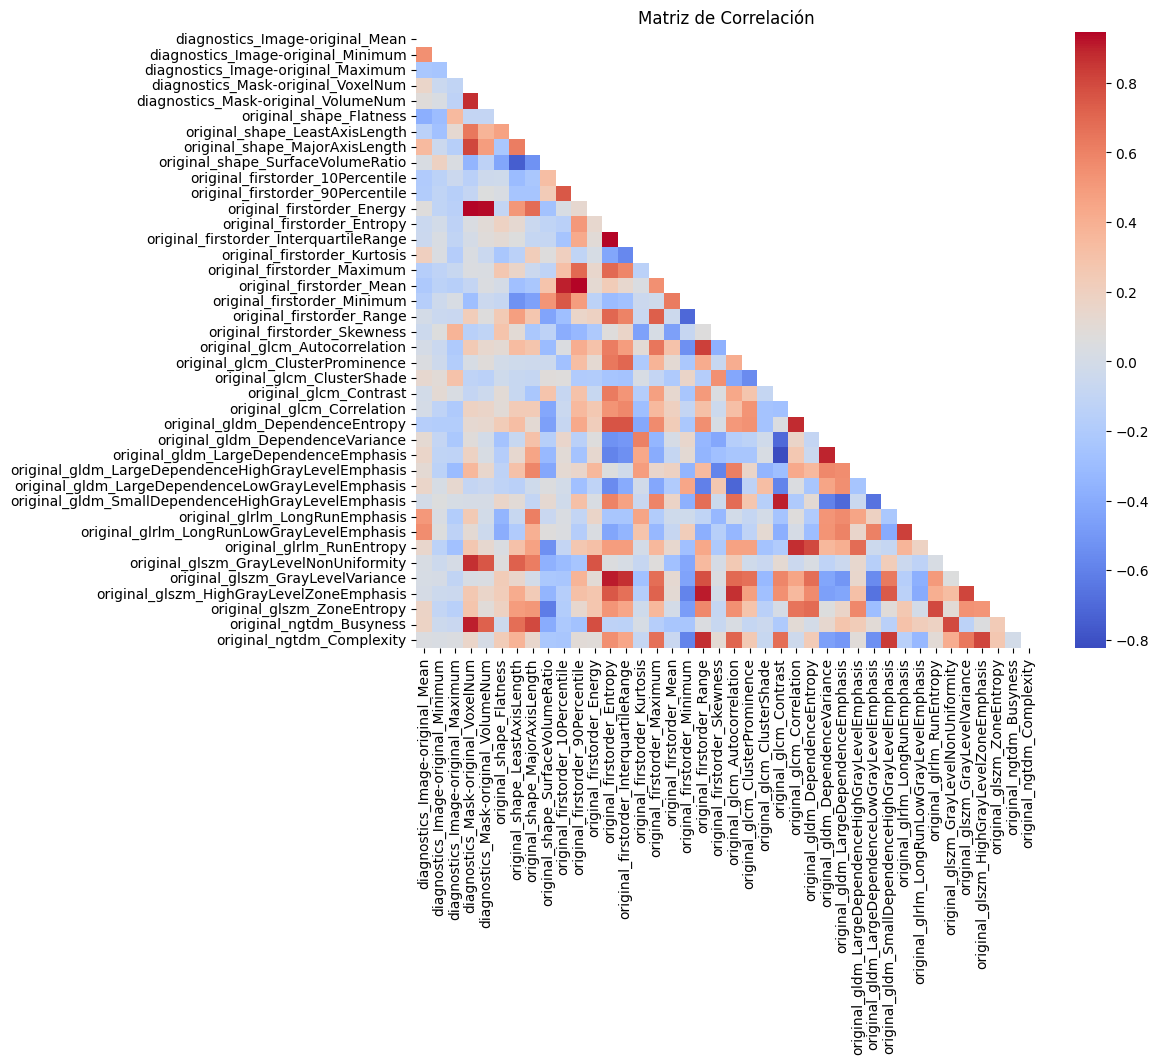

In [34]:
plot_correlation_matrix(X)

In [35]:
print("Número de condición de X:", np.linalg.cond(X))
# Hay mucha correlacion, pensar en como solucionarlo

Número de condición de X: 2.2156398796714428e+16


Número de condición de X: 2.2156398796714428e+16


/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: Co

Condición de X: 2.4918022084585016e+16


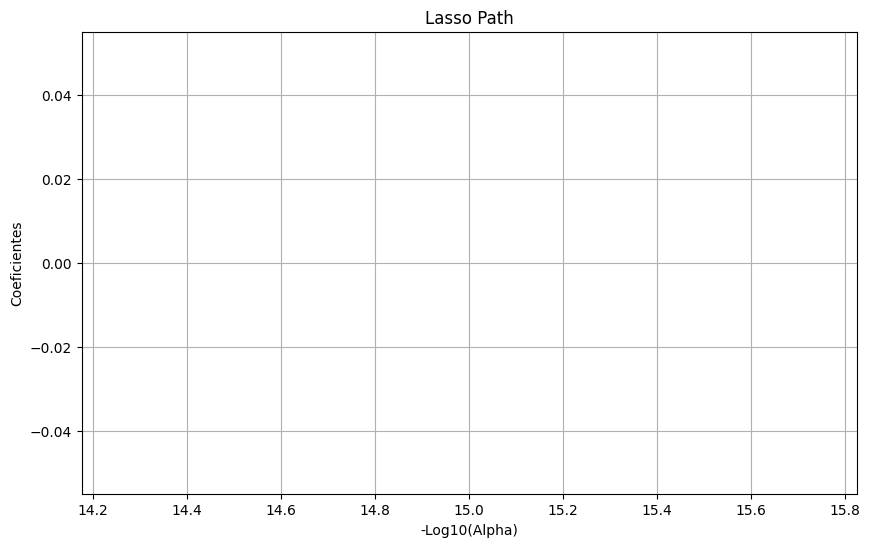

In [36]:
plot_lasso_path(X, y)

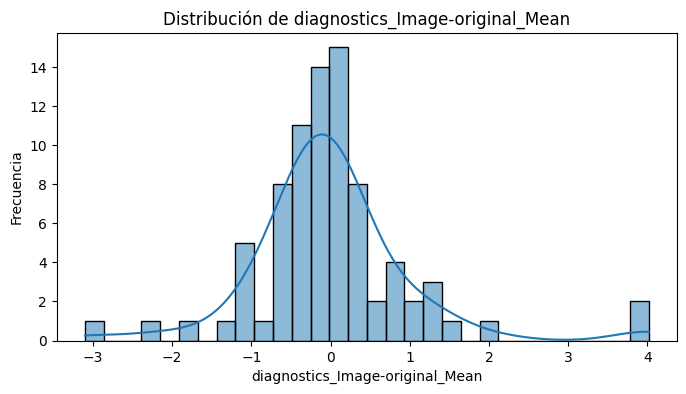

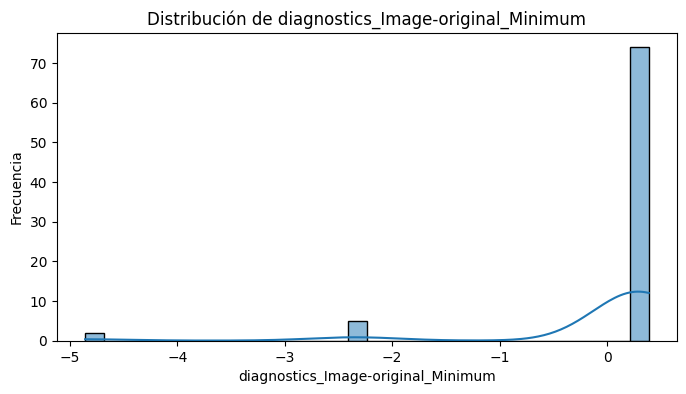

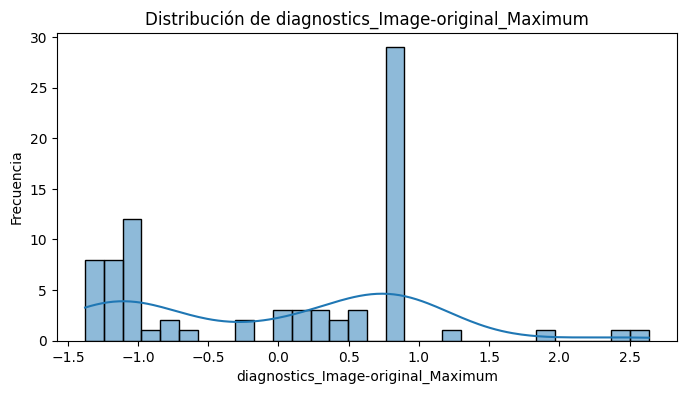

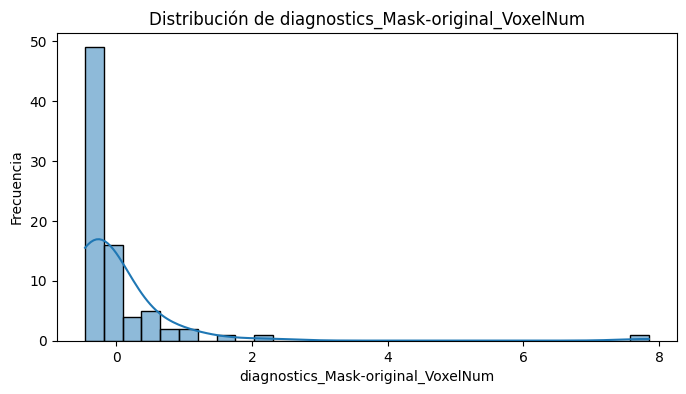

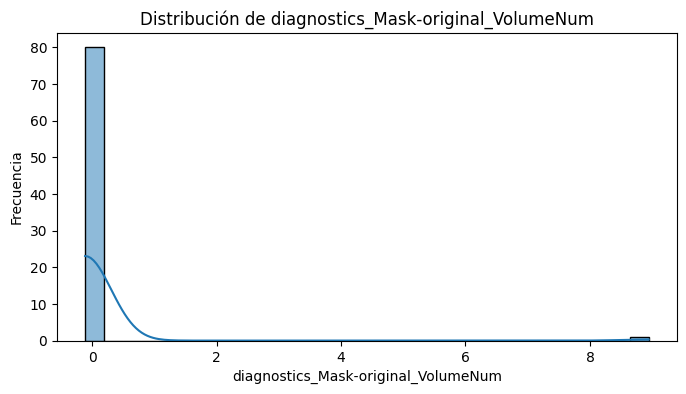

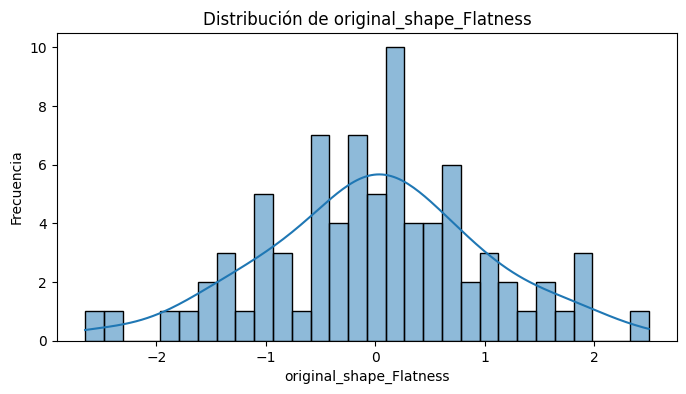

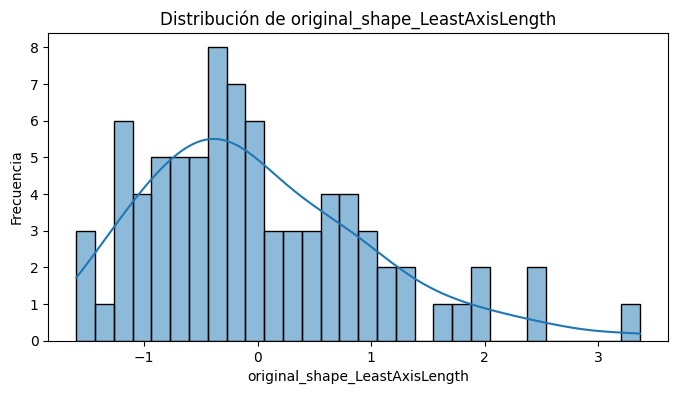

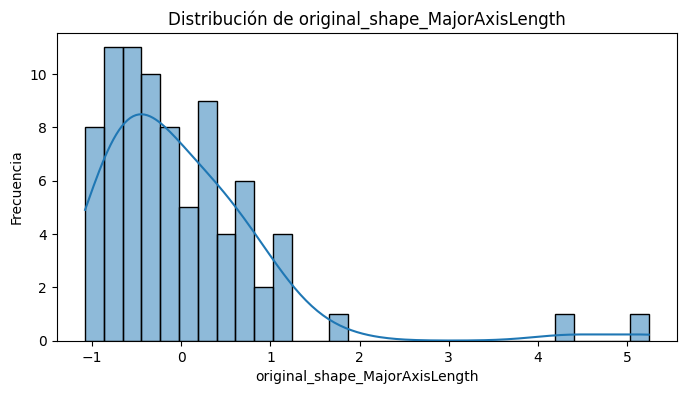

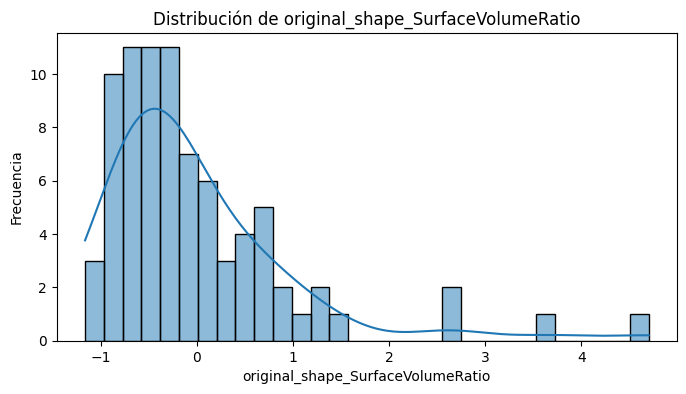

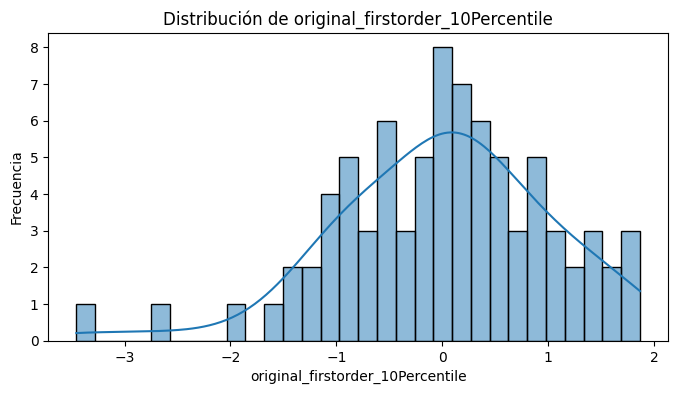

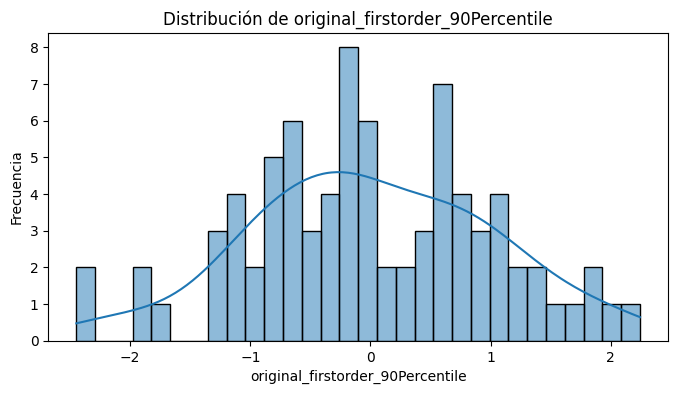

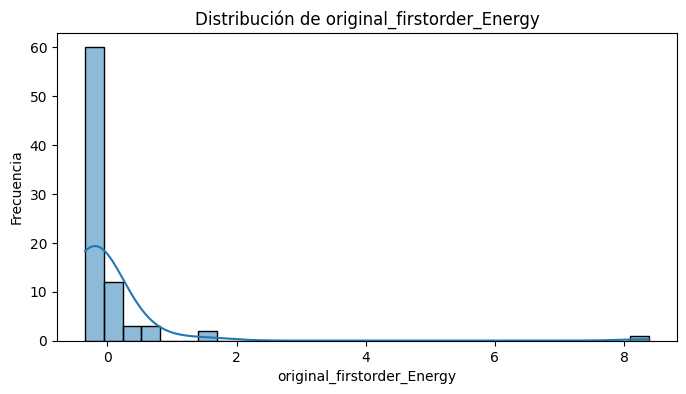

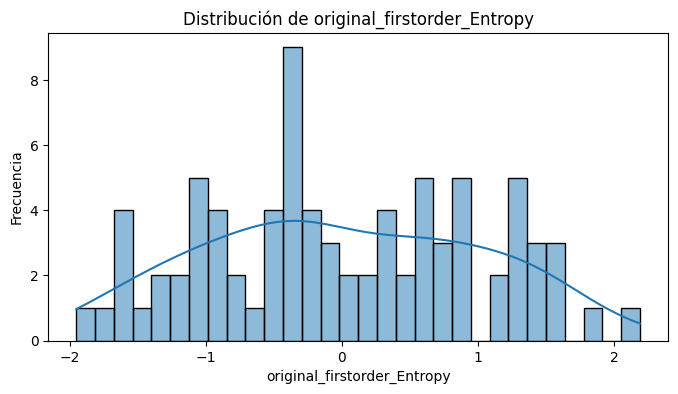

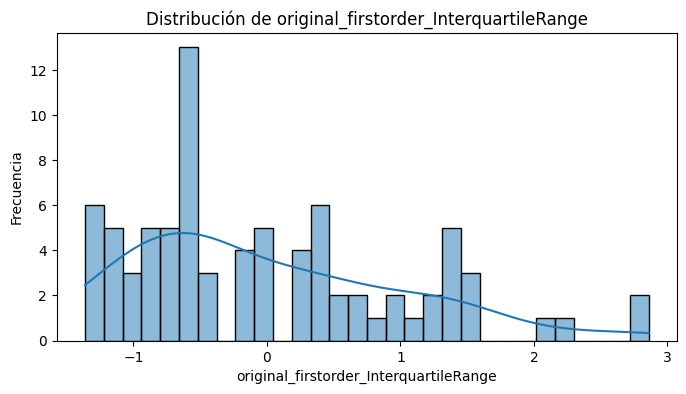

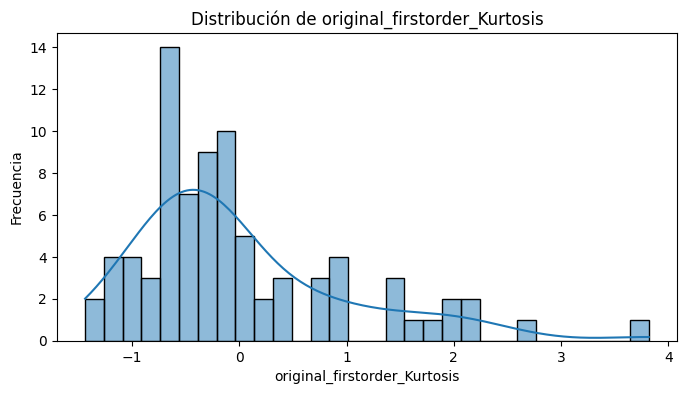

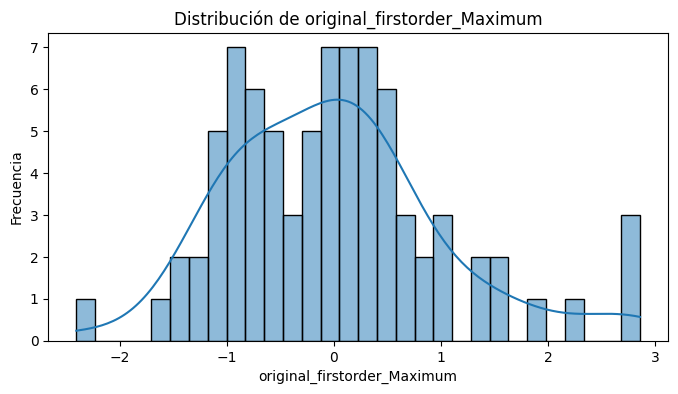

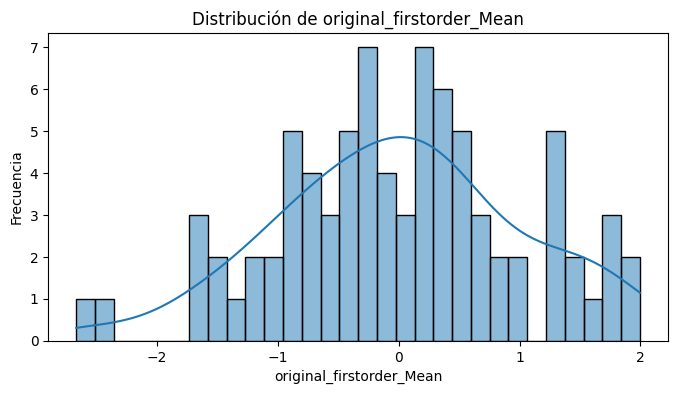

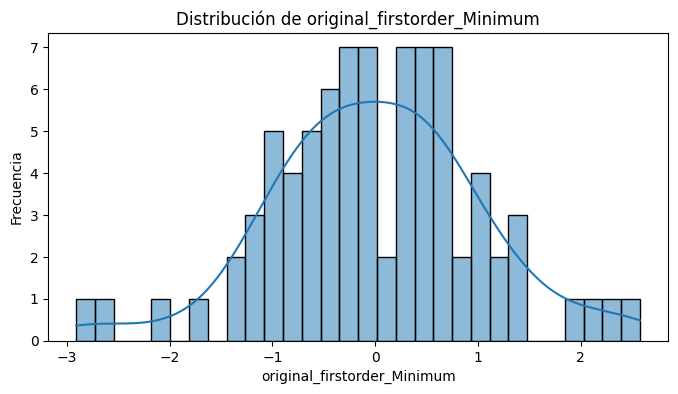

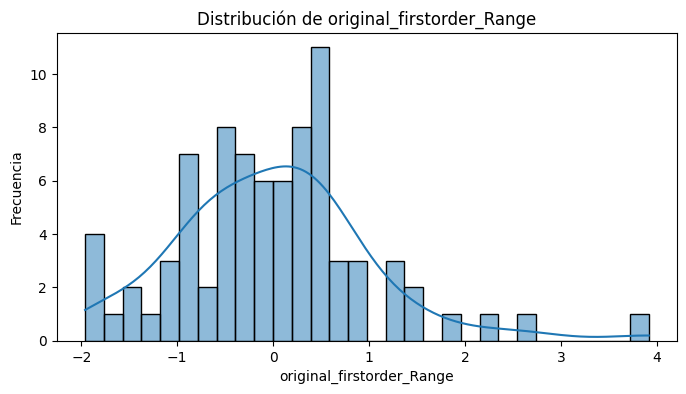

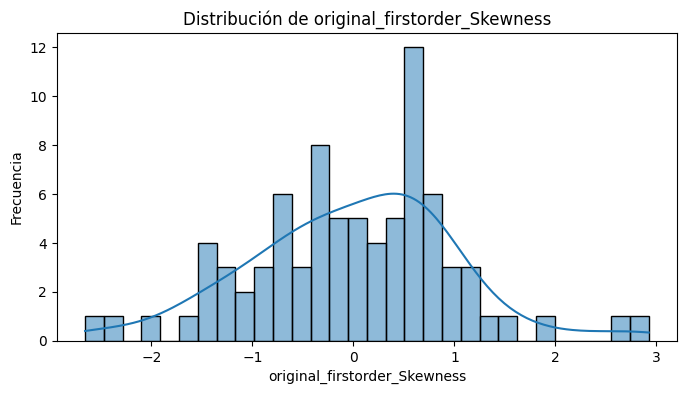

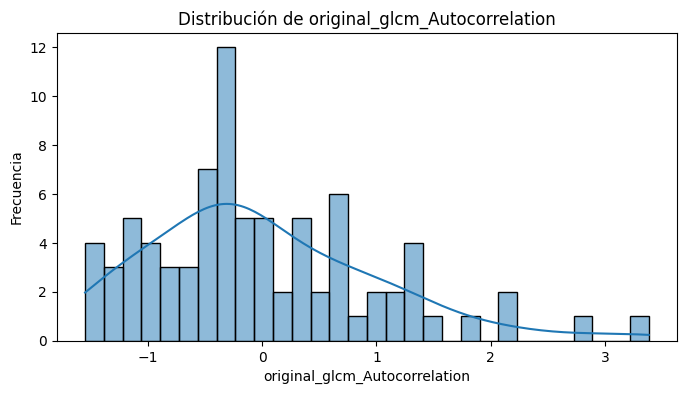

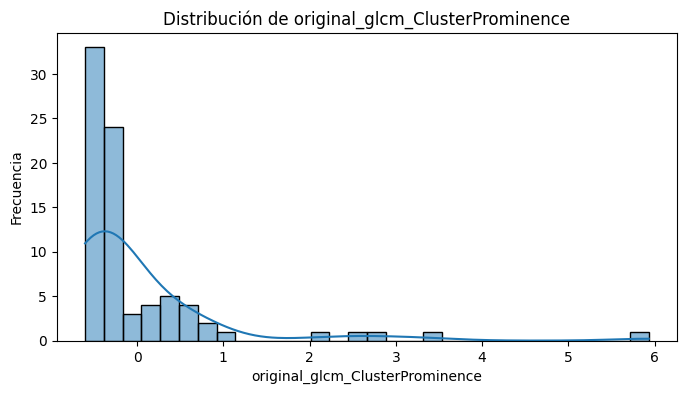

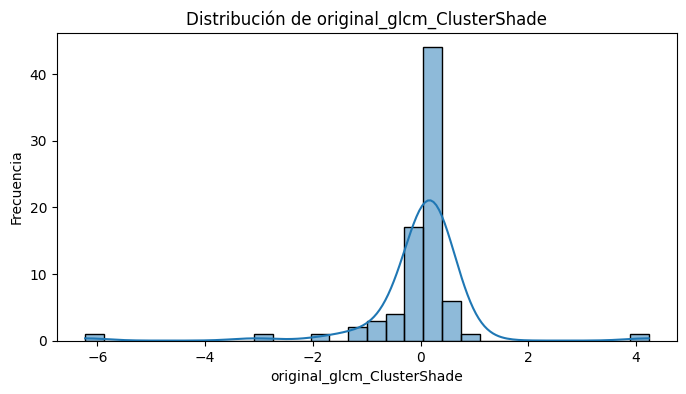

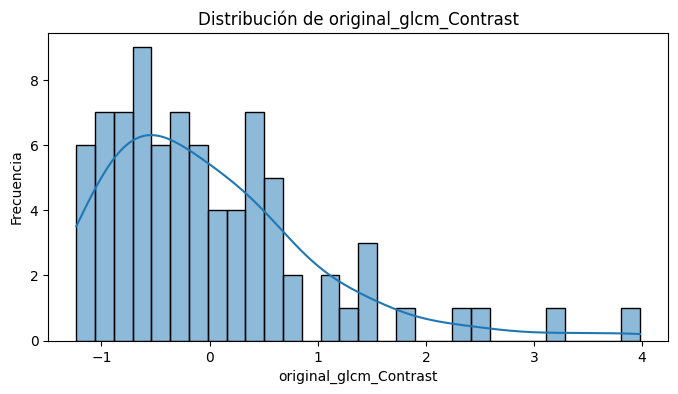

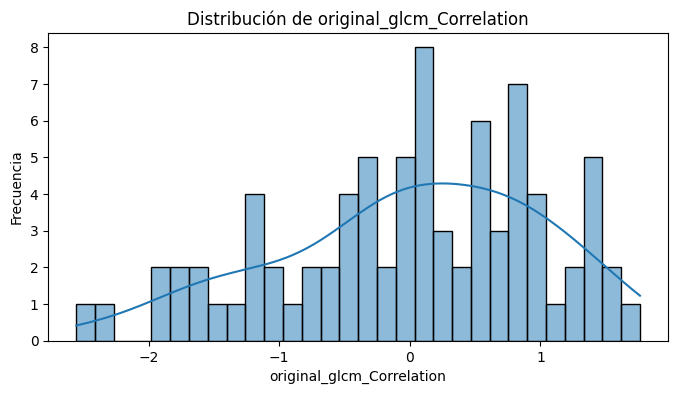

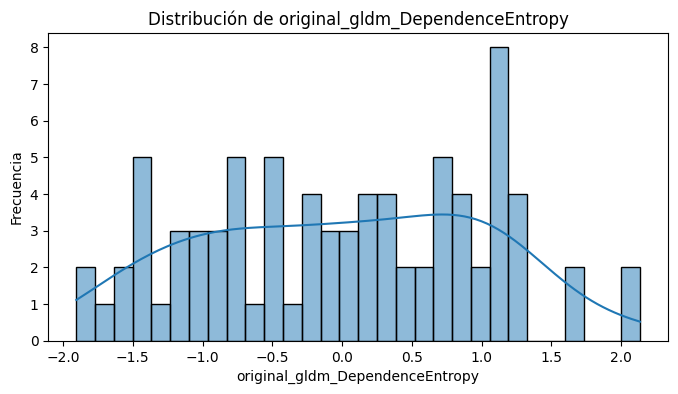

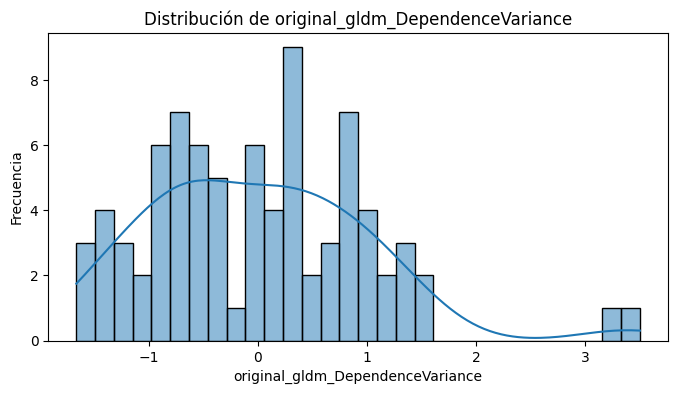

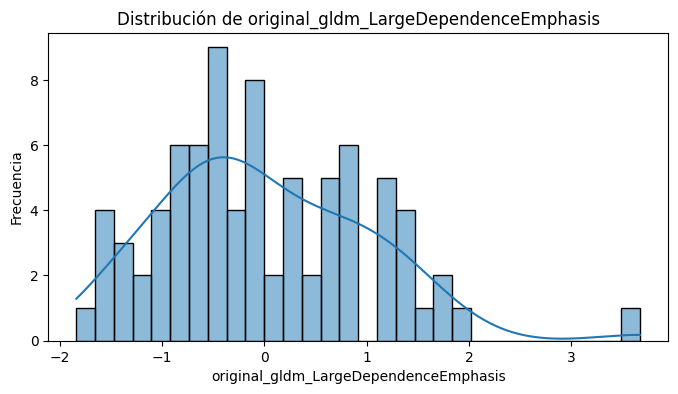

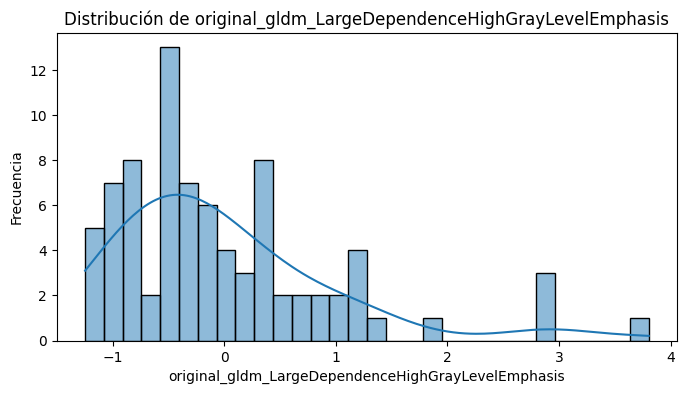

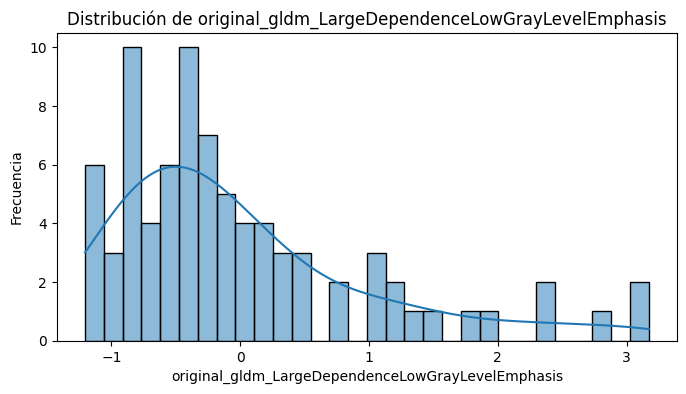

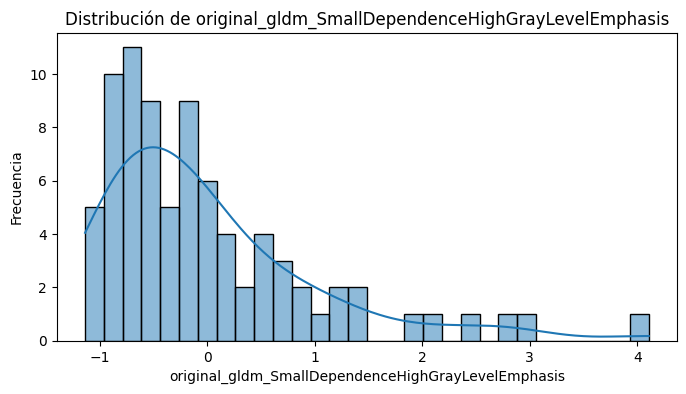

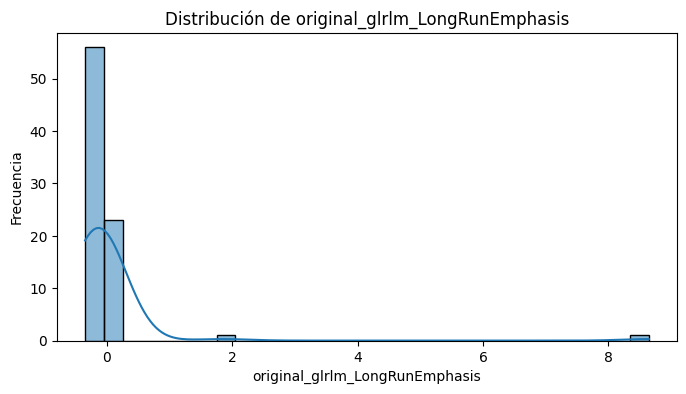

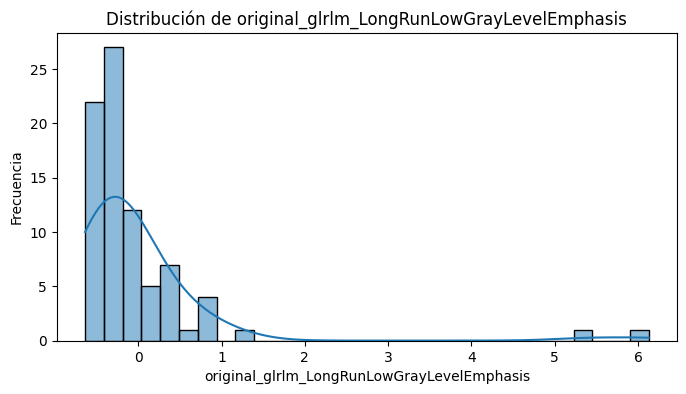

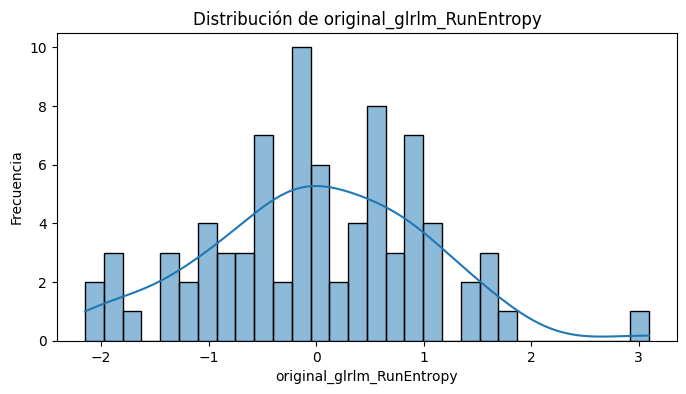

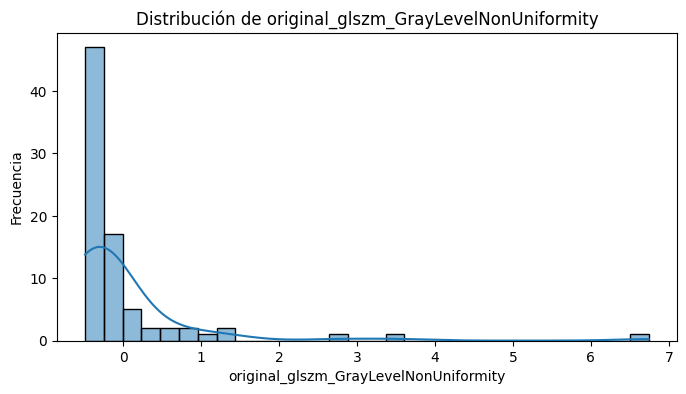

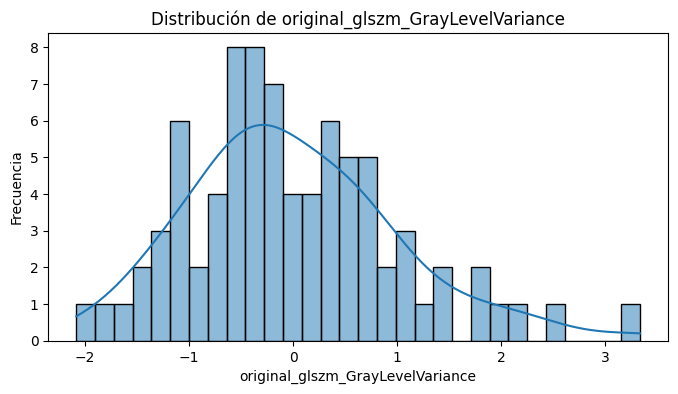

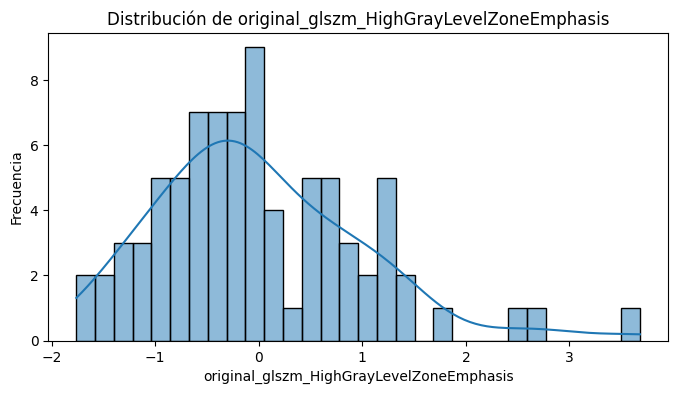

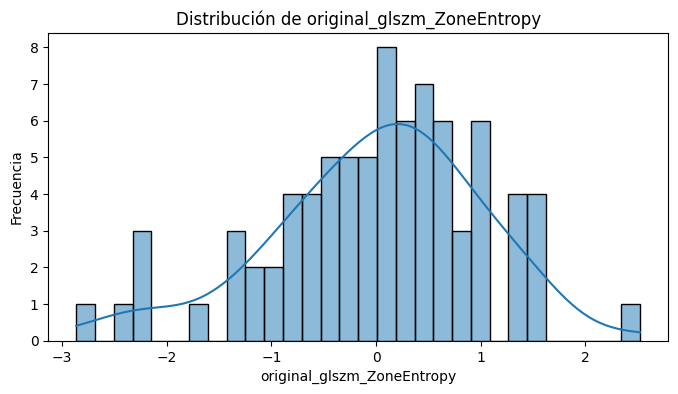

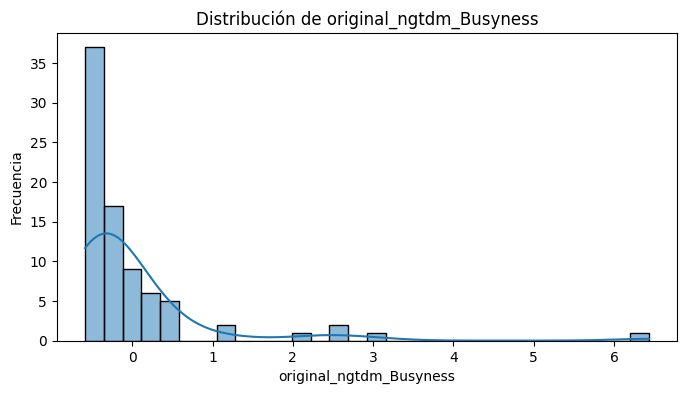

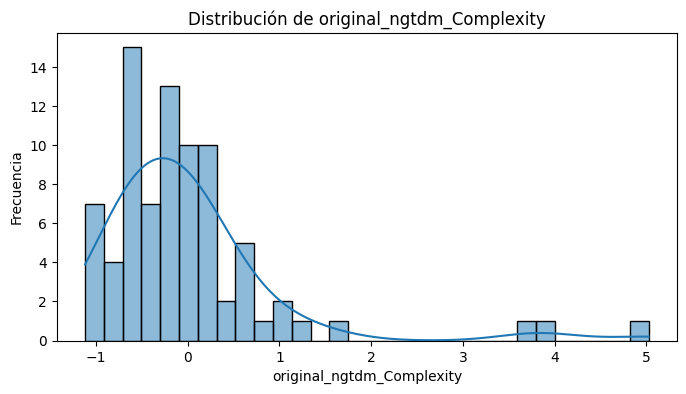

In [37]:
plot_variable_distribution(X)

In [38]:
plot_feature_importance(X, y, features_names)

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
calculate_vif(X)

                                             Variable          VIF
0                     diagnostics_Image-original_Mean     6.386287
1                  diagnostics_Image-original_Minimum     3.726909
2                  diagnostics_Image-original_Maximum     2.910751
3                  diagnostics_Mask-original_VoxelNum   246.772353
4                 diagnostics_Mask-original_VolumeNum   115.275169
5                             original_shape_Flatness    28.207998
6                      original_shape_LeastAxisLength    75.304087
7                      original_shape_MajorAxisLength   169.001017
8                   original_shape_SurfaceVolumeRatio    36.280533
9                    original_firstorder_10Percentile  1429.180582
10                   original_firstorder_90Percentile  2272.084968
11                         original_firstorder_Energy   133.507363
12                        original_firstorder_Entropy  1283.196311
13             original_firstorder_InterquartileRange   112.57

/Users/guillermo/Desktop/Code/myenv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


# Execute models

In [39]:
def train_models(X_train, y_train):
    """
    Entrena múltiples modelos clásicos de ML y los devuelve en un diccionario.
    """
    models = {
        "Logistic Regression": LogisticRegression(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(probability=True)
        }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
    
    return models

def evaluate_models(models, X_test, y_test):
    """
    Evalúa múltiples modelos y devuelve un DataFrame con las métricas.
    """
    results = []
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        results.append([name, accuracy, precision, recall, f1, roc_auc])
        
        print(f"\n{name} - Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
    
    return pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])

def plot_results(results_df):
    """
    Muestra gráficos de barras comparando las métricas de los modelos.
    """
    results_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
    plt.title("Comparación de Modelos")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = train_models(X_train_scaled, y_train)
results_df = evaluate_models(models, X_test_scaled, y_test)

plot_results(results_df)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0